# Simulate linear data and fit it with MCMC

In [1]:
%matplotlib inline
import emcee
import numpy as np
from matplotlib import pyplot

### Simulate some linear data

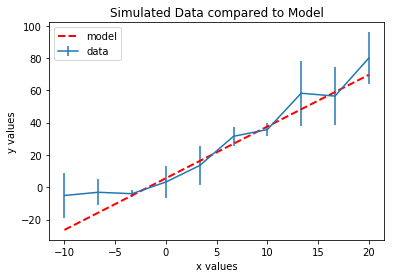

In [2]:
# slope
m = 3.2
# y intercept
b = 5.6
# number of data points to simulate
num_data_points = 10
# error in measurements (different data has different error)
y_data_err = np.array([2.0*(x+1) for x in range(num_data_points)])
#set the seed for reproducibility
np.random.seed(1337)
np.random.shuffle(y_data_err)
# mean of "noise" in the measurement
mean = np.zeros((num_data_points))
# covariance of data
covar = np.zeros((num_data_points,num_data_points))
for i in range(num_data_points):
    covar[i,i] = y_data_err[i]**2

# simulate data
x_data = np.linspace(-10, 20, num=num_data_points)
np.random.seed(42)
y_model = m*x_data + b
y_data = y_model + np.random.multivariate_normal(mean,covar)

# plot data and ideal model
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.errorbar(x_data,y_data,yerr=y_data_err,label='data')
ax.plot(x_data,y_model,'r--',lw=2,label='model')
ax.set_title('Simulated Data compared to Model')
ax.set_xlabel('x values')
ax.set_ylabel('y values')
ax.legend()

### Set up the prior, likelihood, and posterior distribution functions

In [3]:
# Work in log probability space

# log prior
def lnprior(theta):
    slope, intercept = theta
    if -np.inf < slope < np.inf and -np.inf < intercept < np.inf:
        return 0.0
    return -np.inf

# log likelihood function
def lnlike(theta, x, y, yerr):
    slope, intercept = theta
        
    model = slope * x + intercept
    chi_squared = np.sum((y-model)**2/yerr**2)

    return -0.5*chi_squared

# log probability function
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

### Now some emcee! Setup the Ensemble Sampler and run it

In [4]:
#Set up some walkers in a gaussian ball around the maximum likelyhood result
num_params, num_walkers = 2, 100
# initial positions of the walkers
pos = [np.random.randn(num_params) for i in range(num_walkers)]
# set up the sampler
sampler = emcee.EnsembleSampler(num_walkers, num_params, lnprob, args=(x_data,y_data,y_data_err))
#and send it on a walk
sampler.reset()
num_steps = 500
pos0, prob, state = sampler.run_mcmc(pos, num_steps)

### And plot the paths of the walkers

Text(0.5, 0, 'step number')

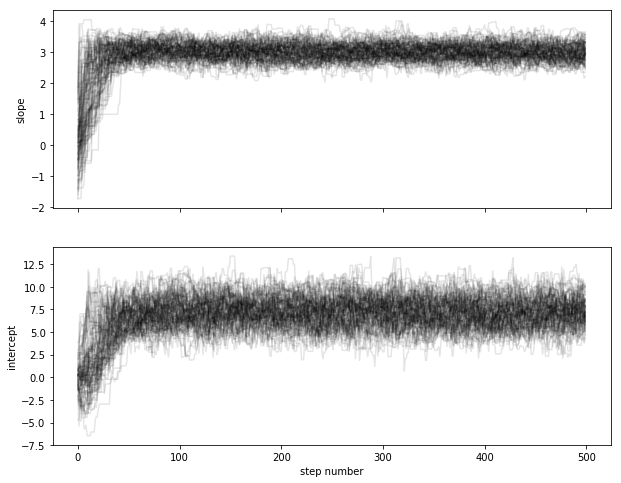

In [5]:
#Plot the "path" of the walkers
xs = np.arange(0,num_steps)

fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(211)
for i in range(num_walkers):
    ax.plot(xs, sampler.chain[i,:,0],'black',alpha=0.1)
ax.set_ylabel('slope')
ax.set_xticklabels([])
ax = fig.add_subplot(212)
for i in range(num_walkers):
    ax.plot(xs, sampler.chain[i,:,1],'black',alpha=0.1)
ax.set_ylabel('intercept')
ax.set_xlabel('step number')

### Generate the Posterior distribution

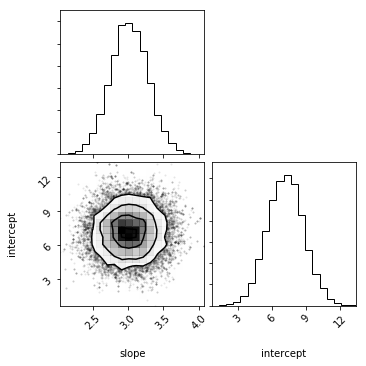

In [6]:
# Now let's plot a triangle plot
# But notice that there's a "burn in" period before the walkers converged
# so we'll skip 100 samples and only use the remaining
samples = sampler.chain[:, 100:, :].reshape((-1, num_params))

import corner
fig = corner.corner(samples, labels=["slope", "intercept"])
fig.savefig("triangle.eps")

In [7]:
# Grab the mean for each parameter and the 1-sigma errorbar
slope_mcmc, intercept_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))

print('Model slope: {:1.5f}'.format(m))
print('Fitted slope: {:1.5f} +{:1.5f} -{:1.5f}'.format(slope_mcmc[0],slope_mcmc[1],slope_mcmc[2]))
print('Model intercept: {:1.5f}'.format(b))
print('Fitted intercept: {:1.5f} +{:1.5f} -{:1.5f}'.format(intercept_mcmc[0],intercept_mcmc[1],intercept_mcmc[2]))

Model slope: 3.20000
Fitted slope: 3.01383 +0.26574 -0.26294
Model intercept: 5.60000
Fitted intercept: 7.20554 +1.56566 -1.61614


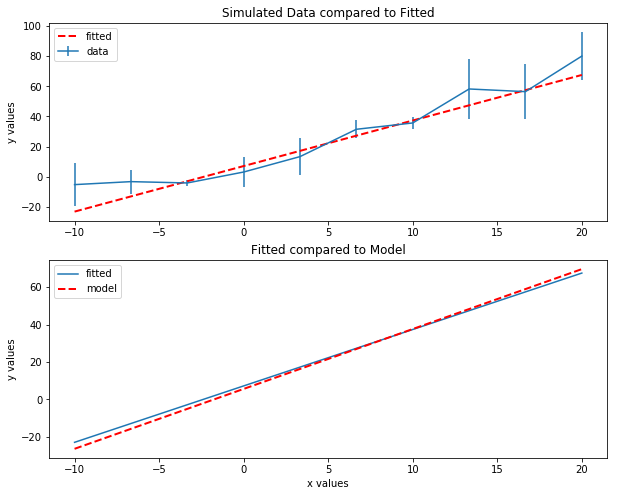

In [8]:
# plot data, ideal model, and fit
y_fitted = slope_mcmc[0] * x_data + intercept_mcmc[0]

fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.errorbar(x_data,y_data,yerr=y_data_err,label='data')
ax.plot(x_data,y_fitted,'r--',lw=2,label='fitted')
ax.set_title('Simulated Data compared to Fitted')
ax.set_ylabel('y values')
ax.legend()
ax = fig.add_subplot(212)
ax.plot(x_data,y_fitted,label='fitted')
ax.plot(x_data,y_model,'r--',lw=2,label='model')
ax.set_title('Fitted compared to Model')
ax.set_xlabel('x values')
ax.set_ylabel('y values')
ax.legend()
